## Project 3: Plausible Utopia 

### Classification Modeling on Subreddits to Classify Scientists and Futurists

### Notebook 1 of 3: Preprocessing, EDA 

### Problem statement

**Question:** Do futurist and scientist interest groups use distinct vocabulary and sentiment? What is the vocabulary of the communities posting on the `futurology` and `science` subreddits?

**Project goal:** Using datasets collected from the [`futurology`](https://www.reddit.com/r/Futurology) and [`science`](https://www.reddit.com/r/Science) subreddits on the social news platform [Reddit](https://www.reddit.com/), I will build classification models to predict which of these two subreddits a given post comes from.

**Models used:** I will use logistic regression, Naive Bayes, and Random Forest classification models. 

**Model evaluation:** I will evaluate the model's performance with accuracy scores.

### Background

[Reddit](https://www.reddit.com/) is a social news platform founded in 2005 and calls itself the "front page of the internet". 

>Reddit is broken up into more than a million communities known as “subreddits,” each of which covers a different topic. The name of a subreddit begins with /r/, which is part of the URL that Reddit uses.

Subreddits are moderated by user ("Redditor") volunteers, and overall the site is administered by Reddit employees, who have the ultimate privileges over subreddits (including banning subreddits and their moderators).

A system of upvoting / downvoting by users increases / decreases (respectively) the visibility of posts.

[Source](https://www.digitaltrends.com/web/what-is-reddit/)


#### Libary imports

In [1163]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

#### Data collection

I utilized the Python Reddit API Wrapper (PRAW) API in the data collection process. You can find the steps I took in the `PRAW_data_collection` notebook, located in the code folder of this repository.

The East Coast local instructors were very generous with their walkthrough of the process, so I definitely credit them for the ease of the data collection.

#### Preprocessing and EDA

#### Dataset 1: "New" submission type, pulled from Reddit on 10/13/20

In [1164]:
subred = pd.read_csv('../data/df_with_both_subs.csv')
subred = subred.drop(columns = 'Unnamed: 0')
display(pd.set_option('display.max_colwidth', 50), subred.head())

None

,title,score,id,url,comms_num,created,body,subreddit
0,What would the point be to do anything if AI c...,0,japxs3,https://www.reddit.com/r/Futurology/comments/j...,4,1.602664e+09,The more I look into AI and new projects like ...,futurology
1,ELCC Explained: the Critical Renewable Energy ...,4,japq75,https://blog.ucsusa.org/mark-specht/elcc-expla...,0,1.602663e+09,NaN,futurology
2,There's a 50-50 chance we're living in a simul...,8,jaojnb,https://boingboing.net/2020/10/13/new-research...,4,1.602659e+09,NaN,futurology
3,"Eight nations sign NASA's Artemis Accords, ple...",3,jaofpy,https://www.engadget.com/nasa-artemis-accords-...,1,1.602658e+09,NaN,futurology
4,Mercedes benz AVTR - In Action,8,jaocqq,https://www.youtube.com/watch?v=ChqM3zqTREQ&ab...,0,1.602658e+09,NaN,futurology


#### Dataset 2: "New" submission type, pulled from Reddit on 10/20/20

In [1165]:
subred_2 = pd.read_csv('../data/df_with_both_subs_2.csv')
display(pd.set_option('display.max_colwidth', 50), subred_2.head())

None

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,flavor
0,Robots Encroach on Up to 800 Million Jobs Arou...,10,jf13r9,https://www.bloombergquint.com/global-economic...,NaN,10,1.00,/r/Futurology/comments/jf13r9/robots_encroach_...,futurology,new
1,Measurement in AI Policy: Opportunities and Ch...,1,jf0178,https://youtu.be/UPNPHpawUCQ,NaN,1,0.66,/r/Futurology/comments/jf0178/measurement_in_a...,futurology,new
2,How Egypt is growing forests in middle of the ...,4,jeziml,https://www.al-monitor.com/pulse/originals/202...,NaN,4,0.83,/r/Futurology/comments/jeziml/how_egypt_is_gro...,futurology,new
3,Energy scavenging nanogenerator finds power al...,12,jeyzrd,https://phys.org/news/2020-10-energy-scavengin...,NaN,12,0.81,/r/Futurology/comments/jeyzrd/energy_scavengin...,futurology,new
4,There are political and cultural problems that...,4,jeyeez,https://www.reddit.com/r/Futurology/comments/j...,"Currently, the life expectancy in the US, cent...",4,0.84,/r/Futurology/comments/jeyeez/there_are_politi...,futurology,new


#### Dataset 3: "Controversial" submission type, pulled from Reddit on 10/20/20

In [1166]:
subred_3 = pd.read_csv('../data/df_with_both_subs_3.csv')
display(pd.set_option('display.max_colwidth', 50), subred_3.head())

None

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,flavor
0,r/Futurology's Official Discord - A relaxed pl...,326,8r1jha,https://discordapp.com/invite/JtaYWC3,NaN,326,0.97,/r/Futurology/comments/8r1jha/rfuturologys_off...,futurology,controversial
1,Climate Change Mega-Thread,87,jag7ht,https://www.reddit.com/r/Futurology/comments/j...,Please post all climate change news here unles...,87,0.86,/r/Futurology/comments/jag7ht/climate_change_m...,futurology,controversial
2,The US government plans to file antitrust char...,13942,jep8br,https://www.theverge.com/2020/10/20/21454192/g...,NaN,13942,0.96,/r/Futurology/comments/jep8br/the_us_governmen...,futurology,controversial
3,"""Medicines that defeat aging have at least a 5...",28158,je6yaq,https://www.pairagraph.com/dialogue/952f0d6309...,NaN,28158,0.85,/r/Futurology/comments/je6yaq/medicines_that_d...,futurology,controversial
4,Energy scavenging nanogenerator finds power al...,38,jewchg,https://phys.org/news/2020-10-energy-scavengin...,NaN,38,0.97,/r/Futurology/comments/jewchg/energy_scavengin...,futurology,controversial


#### Dataset 4: "Top" submission type, pulled from Reddit on 10/20/20

In [1167]:
subred_4 = pd.read_csv('../data/df_with_both_subs_4.csv')
display(pd.set_option('display.max_colwidth', 50), subred_4.head())

None

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,flavor
0,Elon Musk: We know we'll run out of dead dinos...,146990,a9rjmr,https://www.cnbc.com/2018/12/14/elon-musk-this...,NaN,146990,0.87,/r/Futurology/comments/a9rjmr/elon_musk_we_kno...,futurology,top
1,F.C.C. Announces Plan to Repeal Net Neutrality,146291,7ejbyf,https://www.nytimes.com/2017/11/21/technology/...,NaN,146291,0.90,/r/Futurology/comments/7ejbyf/fcc_announces_pl...,futurology,top
2,"Andrew Yang launches nonprofit, called Humanit...",103964,fdyn58,https://edition.cnn.com/2020/03/05/politics/an...,NaN,103964,0.84,/r/Futurology/comments/fdyn58/andrew_yang_laun...,futurology,top
3,"It's time to implement a 4-day workweek, Andre...",101762,i7usdh,https://www.businessinsider.com/andrew-yang-pa...,NaN,101762,0.87,/r/Futurology/comments/i7usdh/its_time_to_impl...,futurology,top
4,Biden will announce on Tuesday a new plan to s...,91318,hr4utb,https://www.nytimes.com/2020/07/14/us/politics...,NaN,91318,0.79,/r/Futurology/comments/hr4utb/biden_will_annou...,futurology,top


#### Combine dataframes

In [1168]:
subred = pd.concat([subred_2, subred_3, subred_4])

# Modify the `flavor` column name to be more specific: new, controversial, etc. are submission types
subred['submission_type'] = subred['flavor']
subred.drop(columns = 'flavor', inplace = True)

subred.head()

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,submission_type
0,Robots Encroach on Up to 800 Million Jobs Arou...,10,jf13r9,https://www.bloombergquint.com/global-economic...,NaN,10,1.00,/r/Futurology/comments/jf13r9/robots_encroach_...,futurology,new
1,Measurement in AI Policy: Opportunities and Ch...,1,jf0178,https://youtu.be/UPNPHpawUCQ,NaN,1,0.66,/r/Futurology/comments/jf0178/measurement_in_a...,futurology,new
2,How Egypt is growing forests in middle of the ...,4,jeziml,https://www.al-monitor.com/pulse/originals/202...,NaN,4,0.83,/r/Futurology/comments/jeziml/how_egypt_is_gro...,futurology,new
3,Energy scavenging nanogenerator finds power al...,12,jeyzrd,https://phys.org/news/2020-10-energy-scavengin...,NaN,12,0.81,/r/Futurology/comments/jeyzrd/energy_scavengin...,futurology,new
4,There are political and cultural problems that...,4,jeyeez,https://www.reddit.com/r/Futurology/comments/j...,"Currently, the life expectancy in the US, cent...",4,0.84,/r/Futurology/comments/jeyeez/there_are_politi...,futurology,new


---

### EDA

In [1169]:
printmd("**`body` text is minimal, let's drop that column**")
display(subred.groupby('subreddit').count())
print('\n')
printmd('**The balance of classes is fairly balanced**')
subred['subreddit'].value_counts(normalize = True)

**`body` text is minimal, let's drop that column**

,title,score,id,url,body,ups,upvote_ratio,permalink,submission_type
subreddit,,,,,,,,,
futurology,2400,2400,2400,2400,120,2400,2400,2400,2400
science,2279,2279,2279,2279,15,2279,2279,2279,2279


**The balance of classes is fairly balanced**

futurology    0.51293
science       0.48707
Name: subreddit, dtype: float64

#### Address duplicates

In [1170]:
printmd('**Instances of each title:**')
duplicates = (pd.DataFrame(subred.groupby('title').count()['subreddit'])
                                .sort_values('subreddit', ascending = False))

duplicates = duplicates[duplicates['subreddit'] > 1]
duplicates.head()

**Instances of each title:**

,subreddit
title,
Scientists Found a New Way to Control the Brain With Light—No Surgery Required,6
"A rectangular robot as tiny as a few human hairs can travel throughout a colon by doing back flips, engineers have demonstrated in live animal models. Backflips because The goal is to use the robots to transport drugs in humans, whose colons and other organs have rough terrain. Side flips work, too.",6
"For the First Time Ever, Scientists Caught Time Crystals Interacting",4
Gravitational Test beyond the First Post-Newtonian Order with the Shadow of the M87 Black Hole,4
"Decent living for all does not have to cost the Earth. Global energy consumption in 2050 could be reduced to the levels of the 1960s and still provide a decent standard of living for a population three times larger, according to a new study.",4


In [1171]:
# Check out duplicated titles - there's a bunch!
subred[subred.duplicated(subset=['title'])].head()

printmd('**Count of unique titles:**')
display(subred['title'].nunique())
printmd('**Count of titles before dropping duplicates:**')
display(subred['title'].count())

non_title_cols = [col for col in subred.columns if col != 'title']

subred = subred.drop_duplicates(subset = ['title']).copy()

printmd('**Count of titles after dropping duplicates:**')
display(subred['title'].nunique())

printmd('**Shape of dataframe after dropping duplicates:**')
subred.shape

**Count of unique titles:**

3149

**Count of titles before dropping duplicates:**

4679

**Count of titles after dropping duplicates:**

3149

**Shape of dataframe after dropping duplicates:**

(3149, 10)

In [1172]:
printmd('**Value counts:**')
display(subred['subreddit'].value_counts())

printmd('**Value counts by weight:**')
subred['subreddit'].value_counts(normalize = True)

**Value counts:**

futurology    1581
science       1568
Name: subreddit, dtype: int64

**Value counts by weight:**

futurology    0.502064
science       0.497936
Name: subreddit, dtype: float64

In [1173]:
# Null body rows
printmd(f"**Only {len(subred['body'][(subred['body'].isnull()).astype(int) == 0])} non-null `body` records. Ignore `body` column since there are so few in the dataset.**")

subred.drop(columns ='body', inplace = True)


**Only 72 non-null `body` records. Ignore `body` column since there are so few in the dataset.**

---

### Preprocessing
#### Remove content that likely does not help inform the classification result
- Remove special characters
- Tokenize
- Lemmatize / stem
- Remove stop words

#### Add features that may help to inform EDA and/ or the classification result

#### Remove punctuation

In [1174]:
# This function is going to remove punctuation and make the text lower case

def remove_punctuation(text):
    lower = text.lower()  
    exclude = string.punctuation  #identifies punctuation marks
    return "".join(ch for ch in lower if ch not in exclude) 
   
    #this iterates through each character, if the character is not a punctuation mark it will join to the empty string

subred['title'] = subred['title'].apply(remove_punctuation)

# ref: Heather Robinson at General Assembly :-)

subred['title'].head(5)

0    robots encroach on up to 800 million jobs arou...
1    measurement in ai policy opportunities and cha...
2    how egypt is growing forests in middle of the ...
3    energy scavenging nanogenerator finds power al...
4    there are political and cultural problems that...
Name: title, dtype: object

#### Regex tokenizing

In [1175]:
printmd('**Here we use a tokenizer that splits the text using regular expressions. It keeps the following:**')
printmd("`\D` = any character that is not a digit")
printmd("`w+` = any word character that occurs one or more times")

# Instantiate the tokenizer, define the function and apply it to the text
regexp_tokenizer = RegexpTokenizer('[\D]')

def regexp_tokenize(string):
    return ''.join(regexp_tokenizer.tokenize(string))

subred['title'] = subred['title'].apply(regexp_tokenize)
subred['title'].head()

**Here we use a tokenizer that splits the text using regular expressions. It keeps the following:**

`\D` = any character that is not a digit

`w+` = any word character that occurs one or more times

0    robots encroach on up to  million jobs around ...
1    measurement in ai policy opportunities and cha...
2    how egypt is growing forests in middle of the ...
3    energy scavenging nanogenerator finds power al...
4    there are political and cultural problems that...
Name: title, dtype: object

**Lemmatizing**, ***aka Soft wash***

In [1176]:
# lemmatizer = WordNetLemmatizer()

# def split_and_lemmatize(string):
#     word = ''
#     for i in string.split():
#         word += lemmatizer.lemmatize(i + ' ')
#     return word

# # Lemmatize titles

# display(subred['title'].apply(split_and_lemmatize).head(1))

**Stemming**, ***aka Aggressive wash***

In [1177]:
stemmer = PorterStemmer()  #instantiate stemmer

def split_and_stem(string):
    word = ""   #empty string
    string = string.split(' ') #creates list of words
    for i in string: #iterates through that list of words
        word += (stemmer.stem(i) + " ")  #stems each word and adds to empty string
    return word  #returns string with stemmed words

# Apply stemming to title 

subred['title'] = subred['title'].apply(split_and_stem)

# ref: Heather Robinson at General Assembly :-)

subred['title'].head()

0    robot encroach on up to  million job around th...
1           measur in ai polici opportun and challeng 
2     how egypt is grow forest in middl of the desert 
3    energi scaveng nanogener find power all around...
4    there are polit and cultur problem that occur ...
Name: title, dtype: object

#### Check for balance of `submission_type` classes

In [1178]:
printmd('**The balance of `submission_type` classes is basically even between `new` and `top`, and `controversial` is tiny**')
display(subred['submission_type'].value_counts(normalize = True))

printmd('**Before the drop: Are there any `controversial` titles worth keeping? By a very subjective process of elimination, I am deciding to drop all these titles**')

(display(pd.set_option('display.max_colwidth', 500), 
        pd.DataFrame(subred[subred['submission_type'] == 'controversial']['title'])))

# New dataframe only contains rows where submission_type is not controversial
subred = subred[subred['submission_type'] != 'controversial']

printmd('**After the drop:**')
display(subred['submission_type'].value_counts(normalize = True))

**The balance of `submission_type` classes is basically even between `new` and `top`, and `controversial` is tiny**

new              0.501429
top              0.494760
controversial    0.003811
Name: submission_type, dtype: float64

**Before the drop: Are there any `controversial` titles worth keeping? By a very subjective process of elimination, I am deciding to drop all these titles**

None

,title
0,rfuturolog offici discord a relax place to chill and discuss all thing futurolog
744,south korea will launch g trial in with tbp speed and th latenc of g
778,a team of nasa research seek a new energi sourc for deepspac explor mission recent reveal a method for trigger nuclear fusion in the space between the atom of a metal solid
784,money is worth noth now how lebanon is find a futur in farm
788,weve long wait for fusion thi reactor may final deliv it—fast scientist say their compact reactor could be up and run in just year that would be unpreced
793,the sever downturn in air traffic thi year caus by covid follow by a slow recoveri will result in a loss of up to million job normal support by aviat around the globe accord to new industri figur releas today
799,satir is dead hopium will be the name of thi futur french hydrogen car meant to compet with tesla model s
832,bing drink caus liver damag by reduc cellular level of nad
1475,use weed dure pregnanc link to psychoticlik behavior in children studi find studi of children
1476,transmiss dynam reveal the impract of covid herd immun strategi a new studi simul sarscov spread in the uk find that achiev herd immun without overwhelm hospit capac leav littl room for error


**After the drop:**

new    0.503347
top    0.496653
Name: submission_type, dtype: float64

#### Add a word count column in case it has any significance 

In [1179]:
subred['title_word_count'] = subred['title'].apply(lambda x: len(x.split()))

#### Binarizing the target feature: `1` for Science, `0` for Futurology

In [1180]:
# Check the balance of classes

printmd('**Balance of classes**')
display(subred['subreddit'].value_counts())
display(subred['subreddit'].value_counts(normalize = True))

subred['subreddit'] = subred['subreddit'].map({'science': 1, 'futurology': 0})

printmd('**Balance of classes after binarizing (Science: 1, Futurology: 0)**')
display(subred['subreddit'].value_counts(normalize = True))

**Balance of classes**

futurology    1574
science       1563
Name: subreddit, dtype: int64

futurology    0.501753
science       0.498247
Name: subreddit, dtype: float64

**Balance of classes after binarizing (Science: 1, Futurology: 0)**

0    0.501753
1    0.498247
Name: subreddit, dtype: float64

In [1181]:
printmd(f"### The baseline accuracy score is {subred['subreddit'].value_counts(normalize = True)[0]:.3f}")

printmd(f"### The simplest model is to predict only the majority class (`futurology`). If we used that model, the predictions would be {subred['subreddit'].value_counts(normalize = True)[0]:.3f} accurate.")
printmd('### We will use this benchmark to compare against the scores that our models generate.')

### The baseline accuracy score is 0.502

### The simplest model is to predict only the majority class (`futurology`). If we used that model, the predictions would be 0.502 accurate.

### We will use this benchmark to compare against the scores that our models generate.

In [1182]:
subred_for_models = subred[['subreddit', 'title']]

subred_for_models.to_csv('../data/cleaned_data/cleaned_df.csv', index = False)

### Cutoff point 

#### To toggle between Option 1 (EDA)  and Option 2 (Optimal modeling) below:
**Step 1**: Click on this cell, then select the following from the Jupyter Notebook menu:  `Cell`  > `Run all above`

**Step 2**: Run the cells within each section below

**Step 3**: After running the last cell within the section, repeat `Step 1`, and go to the next section 

---

#### Set the features and target variable

In [1183]:
# Set feature matrix and target variable

X = subred['title']
y = subred['subreddit']

## EDA



In [1184]:
# Create a dataframe with columns relevant to EDA

subred_for_eda = subred[['title', 'score', 'upvote_ratio', 'ups', 'submission_type', 'subreddit', 'title_word_count']]
subred_for_eda.head(1)

,title,score,upvote_ratio,ups,submission_type,subreddit,title_word_count
0,robot encroach on up to million job around the world,10,1.0,10,new,0,10


### Before vectorizing, let's check out numerical values in the dataset

In [1185]:
printmd('**No strong correlations with the `subreddit` target column, but we do need to drop the `score` columns (duplicate of `ups`)**')
display(subred_for_eda.corr()['subreddit'])

# Confirm the two columns are the same
subred_for_eda[['ups', 'score']].sum()

# Drop `score`
subred_for_eda.drop(columns = 'score', inplace = True)

**No strong correlations with the `subreddit` target column, but we do need to drop the `score` columns (duplicate of `ups`)**

score               0.199984
upvote_ratio       -0.027595
ups                 0.199984
subreddit           1.000000
title_word_count    0.262234
Name: subreddit, dtype: float64

In [1186]:
printmd('**The mean number of ups for the `top` category is much higher than the others (aptly named!)**')
submission_type_means = subred_for_eda.groupby('submission_type').mean()
submission_type_means

**The mean number of ups for the `top` category is much higher than the others (aptly named!)**

,upvote_ratio,ups,subreddit,title_word_count
submission_type,,,,
new,0.811995,2064.671944,0.500317,21.034199
top,0.885687,44386.410783,0.496149,31.431964


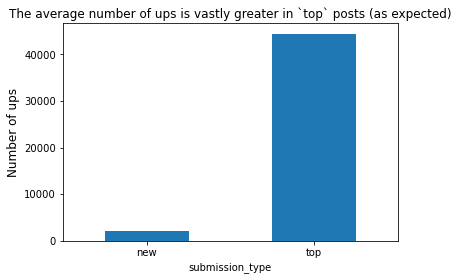

In [1187]:
plt.figure(figsize=[6, 4])

submission_type_means['ups'].plot(kind = 'bar')

plt.title('The average number of ups is vastly greater in `top` posts (as expected)')
plt.ylabel('Number of ups', size = 12)
plt.xticks(rotation = 0);

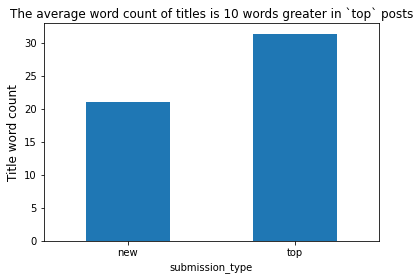

In [1188]:
plt.figure(figsize=[6, 4])

submission_type_means['title_word_count'].plot(kind = 'bar')

plt.title('The average word count of titles is 10 words greater in `top` posts')
plt.ylabel('Title word count', size = 12)
plt.xticks(rotation = 0);

Text(0.5, 0, 'Number of ups')

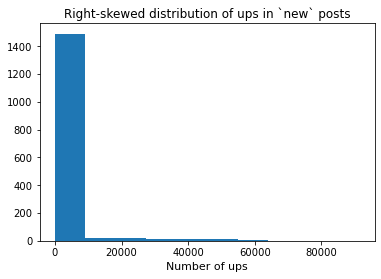

In [1189]:
plt.hist(subred_for_eda[subred_for_eda['submission_type'] == 'new']['ups'])
plt.title('Right-skewed distribution of ups in `new` posts', size = 12)
plt.xlabel('Number of ups', size = 11)

Text(0.5, 0, 'Number of ups')

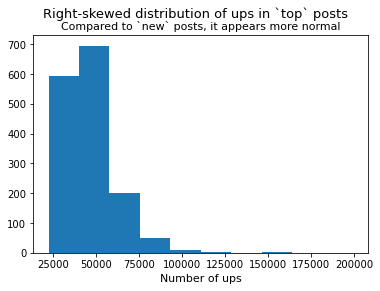

In [1190]:
plt.hist(subred_for_eda[subred_for_eda['submission_type'] == 'top']['ups'])
plt.suptitle('Right-skewed distribution of ups in `top` posts', size = 13)
plt.title("Compared to `new` posts, it appears more normal", size = 11)
plt.xlabel('Number of ups', size = 11)

In [1191]:
# Check out top posts
subred[subred['submission_type']=='top'].head(1)

,title,score,id,url,ups,upvote_ratio,permalink,subreddit,submission_type,title_word_count
0,elon musk we know well run out of dead dinosaur to mine for fuel have to use sustain energi eventu so whi not go renew now avoid increas risk of climat catastroph bet that scienc is wrong oil compani are right is the dumbest experi in histori by far,146990,a9rjmr,https://www.cnbc.com/2018/12/14/elon-musk-this-is-why-i-push-myself.html,146990,0.87,/r/Futurology/comments/a9rjmr/elon_musk_we_know_well_run_out_of_dead_dinosaurs/,0,top,49


### Bag of Words analysis

#### CountVectorizer

1. Count number of times a token is observed in a given subreddit post

2. Create a vector to store those counts

In [1192]:
subred = subred[['title', 'subreddit']]

#### Create a document-term matrix to match up the subreddits and words

In [1193]:
# Apply stemming to the `title` column
subred['title'] = subred['title'].apply(split_and_stem)

# Joins all stemmed text from `title` column, groups by `subreddit` column
subred_grouped_by_sub = subred[['subreddit', 'title']].groupby(by = 'subreddit').agg(lambda x: ' '.join(x))

# Instantiate CountVectorizer
cv = CountVectorizer(
                     analyzer = 'word',
                     stop_words = 'english',
                     ngram_range = (1, 2),
                    )

# Fit the `title` column to the vocabulary (aka, learn it), transform words/ n-grams into vectors
subred_grouped_by_sub_new = cv.fit_transform(subred_grouped_by_sub['title'])

# Set up document-term matrix dataframe that pairs word vectors with their count in each `subreddit`
df_doc_term_matrix = pd.DataFrame(subred_grouped_by_sub_new.todense(), columns = cv.get_feature_names())

# Bring `subreddit` back into the dataframe
df_doc_term_matrix['subreddit'] = subred_grouped_by_sub.index
subreddit_col = df_doc_term_matrix.pop('subreddit')
df_doc_term_matrix.insert(0, 'subreddit', subreddit_col)

df_doc_term_matrix

# ref: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

,subreddit,aaa,aaa scientist,aalto,aalto univ,ab,ab increa,abandon,abandon coal,abandon invest,abandon land,abandon leav,abandon stay,abdomen,abdomen larg,abduct,abduct neardeath,aberdeen,aberdeen citi,aberr,aberr new,aberr synapt,abet,abet spread,abil,abil absorb,abil academ,abil adequ,abil connect,abil contract,abil control,abil cooper,abil current,abil deepfak,abil delay,abil evalu,abil fight,abil identifi,abil invad,abil lemur,abil magic,abil maintain,...,zeroemiss,zeroemiss fuel,zeroemiss mark,zeroemiss plane,zeroemiss vehicl,zerotol,zerotol messag,zhengzhou,zhengzhou railway,zika,zika like,zinc,zinc author,zinc children,zinc zn,ziplin,ziplin unit,zircon,zircon hyperson,zn,zn base,zombi,zombi fires,zombi gene,zombi occur,zone,zone diver,zone estuari,zone ha,zone saw,zoologist,zoologist uncov,zoonot,zoonot transmiss,zuckerberg,zuckerberg differ,zurbuchen,zurbuchen nasa,αcmₚmₑ½,αcmₚmₑ½ km,μg,μg dose
0,0,1,1,0,0,0,0,4,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,5,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,...,4,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,2,1,0,1,2,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0
1,1,0,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,0,25,0,1,1,1,1,1,1,1,0,2,1,1,1,1,2,0,0,...,0,0,0,0,0,1,1,0,0,0,0,2,1,1,0,0,0,0,0,0,0,1,0,1,0,2,0,0,1,1,1,1,1,1,0,0,0,0,1,1,2,2


#### Most common words

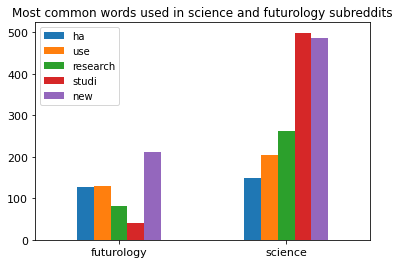

In [1194]:
# Most common words used in science and futurology subreddits

top_words = df_doc_term_matrix.iloc[:, 1:].sum().sort_values(ascending = False)[:5][::-1]
top_words = df_doc_term_matrix[[word for word in pd.Series(top_words).index]]
top_words.index = [ 'futurology', 'science']
top_words

top_words.plot.bar()

plt.title('Most common words used in science and futurology subreddits')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11);

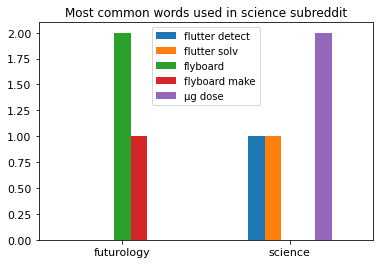

In [1195]:
# Most common words used in science subreddit

top_words_science_only = (df_doc_term_matrix.iloc[:, 1:][df_doc_term_matrix['subreddit'] == 'science']
                                            .sum().sort_values(ascending = False)[:5][::-1])
                            
top_words_science_only = df_doc_term_matrix[[word for word in pd.Series(top_words_science_only).index]]
top_words_science_only.index = ['futurology', 'science']
top_words_science_only

top_words_science_only.plot.bar()

plt.title('Most common words used in science subreddit')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11);

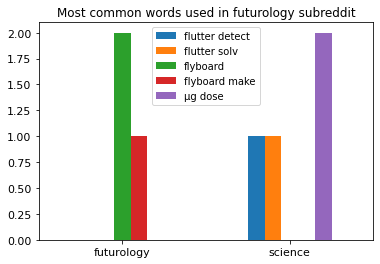

In [1196]:
# Most common words used in futurology subreddit

top_words_futurology_only = (df_doc_term_matrix.iloc[:, 1:][df_doc_term_matrix['subreddit'] == 'futurology']
                                            .sum().sort_values(ascending = False)[:5][::-1])

top_words_futurology_only = df_doc_term_matrix[[word for word in pd.Series(top_words_futurology_only).index]]
top_words_futurology_only.index = ['futurology', 'science']
top_words_futurology_only

top_words_futurology_only.plot.bar()

plt.title('Most common words used in futurology subreddit')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11);

#### Vocabulary size

In [1197]:
# sum_futurology = 0
# for i in range(2, len(df_doc_term_matrix.columns) - 1):
#     sum_futurology += df_doc_term_matrix.iloc[0, i]
# printmd(f'**Sum of `sum_futurology`: {sum_futurology}**')

# sum_science = 0
# for i in range(2, len(df_doc_term_matrix.columns) - 1):
#     sum_science += df_doc_term_matrix.iloc[1, i]
# printmd(f'**Sum of `sum_science`: {sum_science}**')

In [1198]:


# df_doc_term_matrix['grand_total'] = [sum_futurology, sum_science]

# grand_total_col = df_doc_term_matrix.pop('grand_total')
# df_doc_term_matrix.insert(0, 'grand_total', grand_total_col)

In [1199]:
df_doc_term_matrix

,subreddit,aaa,aaa scientist,aalto,aalto univ,ab,ab increa,abandon,abandon coal,abandon invest,abandon land,abandon leav,abandon stay,abdomen,abdomen larg,abduct,abduct neardeath,aberdeen,aberdeen citi,aberr,aberr new,aberr synapt,abet,abet spread,abil,abil absorb,abil academ,abil adequ,abil connect,abil contract,abil control,abil cooper,abil current,abil deepfak,abil delay,abil evalu,abil fight,abil identifi,abil invad,abil lemur,abil magic,abil maintain,...,zeroemiss,zeroemiss fuel,zeroemiss mark,zeroemiss plane,zeroemiss vehicl,zerotol,zerotol messag,zhengzhou,zhengzhou railway,zika,zika like,zinc,zinc author,zinc children,zinc zn,ziplin,ziplin unit,zircon,zircon hyperson,zn,zn base,zombi,zombi fires,zombi gene,zombi occur,zone,zone diver,zone estuari,zone ha,zone saw,zoologist,zoologist uncov,zoonot,zoonot transmiss,zuckerberg,zuckerberg differ,zurbuchen,zurbuchen nasa,αcmₚmₑ½,αcmₚmₑ½ km,μg,μg dose
0,0,1,1,0,0,0,0,4,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,5,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,...,4,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,2,1,0,1,2,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0
1,1,0,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,0,25,0,1,1,1,1,1,1,1,0,2,1,1,1,1,2,0,0,...,0,0,0,0,0,1,1,0,0,0,0,2,1,1,0,0,0,0,0,0,0,1,0,1,0,2,0,0,1,1,1,1,1,1,0,0,0,0,1,1,2,2


In [1200]:
printmd(f'**Vocabulary size by subreddit:**')
display(df_doc_term_matrix.sum(axis = 1))
printmd('**The vocabulary size in `futurology` is much lower than that of `science`**')

**Vocabulary size by subreddit:**

0    42495
1    56104
dtype: int64

**The vocabulary size in `futurology` is much lower than that of `science`**

#### Distribution of post lengths

In [1201]:
printmd(f"#### Overall average word count in `science` and `futurology` titles: {int(subred_for_eda[['subreddit', 'title_word_count']].mean())}")

plt.figure(figsize=[6, 4])

subred_for_eda['title_word_count'].hist(color = 'darkturquoise', grid = False)

plt.title('Overall distribution of word count in titles')
plt.xlabel('Title word count', size = 12)
plt.axvline(int(subred_for_eda[['subreddit', 'title_word_count']].mean()), color = "orange");

TypeError: cannot convert the series to <class 'int'>

In [ ]:
subred_for_eda[subred_for_eda['subreddit'] == 'futurology'].groupby('subreddit')['title_word_count'].hist(color = 'darkturquoise', grid = False)
plt.title('Distribution of word count in `futurology` post titles')
plt.xlabel('Title word count', size = 12)
plt.axvline(int(subred_for_eda[subred_for_eda['subreddit'] == 'futurology'].groupby('subreddit')['title_word_count'].mean()), color = "orange");

In [ ]:
subred_for_eda[subred_for_eda['subreddit'] == 'science'].groupby('subreddit')['title_word_count'].hist(color = 'darkturquoise', grid = False)
plt.title('Distribution of word count in `science` post titles')
plt.xlabel('Title word count', size = 12)
plt.axvline(int(subred_for_eda[subred_for_eda['subreddit'] == 'science'].groupby('subreddit')['title_word_count'].mean()), color = "orange");

#### Use of arbitrary terms one might guess are common in either subreddit

In [ ]:
display(df_doc_term_matrix.groupby(by = 'subreddit')['scienc', 'scientist', 'futur', 'tech', 'technology'].sum())
printmd('**Surprisingly low..**')

### Feature selection / Feature engineering

ref: https://en.wikipedia.org/wiki/Feature_selection

In [ ]:
# Combine top words between subreddits

top_words_cols = []
top_words_cols.append([col for col in top_words.columns])
top_words_cols.append([col for col in top_words_science_only.columns])
top_words_cols.append([col for col in top_words_futurology_only.columns])

top_words_cols_new = []
for sublist in top_words_cols:
    for word in sublist:
        if word not in top_words_cols_new:
            top_words_cols_new.append(word)
        
display(top_words_cols_new)

# ref: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists

# Group columns (including unigrams and bigrams) containing the top words

top_words_cols_new_groups = []
all_cols = df_doc_term_matrix.columns.to_list()
top_words_cols_new

import re

for word in all_cols:
    if re.match('futur', word):
        top_words_cols_new_groups.append(word)
        
top_words_cols_new_groups[:3]        

In [ ]:
[col for col in df_doc_term_matrix.columns if 'futur' in col]

### Top 100 features from Logistic Regression and Random Forest

In [1202]:
feature_selection_logreg = pd.read_csv('../data/feature_selection/feature_selection_logreg.csv')
display(feature_selection_logreg.head())

feature_selection_randomforest = pd.read_csv('../data/feature_selection/feature_selection_randomforest.csv')
display(feature_selection_randomforest.head())


,Unnamed: 0,Coeff
0,studi,4.569888
1,covid,2.735273
2,suggest,2.426959
3,new studi,2.098700
4,research,2.056223


,Unnamed: 0,Coeff
0,studi,0.050425
1,suggest,0.015479
2,covid,0.013561
3,research,0.012980
4,increas,0.009638


In [1205]:
# Create a dataframe by merging the features and their coefficients / weights from the modeling phase

feature_selection_df = (feature_selection_logreg.merge(feature_selection_randomforest,
                               on = 'Unnamed: 0',
                               how = 'outer',
                               suffixes = ('_logreg', '_randomforest')))


feature_selection_df = feature_selection_df.rename(columns = {'Unnamed: 0': 'feature'})
feature_selection_df.columns = feature_selection_df.columns.str.lower()
feature_selection_df


,feature,coeff_logreg,coeff_randomforest
0,studi,4.569888,0.050425
1,covid,2.735273,0.013561
2,suggest,2.426959,0.015479
3,new studi,2.098700,NaN
4,research,2.056223,0.012980
5,increas,1.790901,0.009638
6,effect,1.653257,0.006039
7,dure,1.635006,0.007330
8,peopl,1.596396,0.005657
9,sarscov,1.549757,0.006749


In [1207]:
printmd('**The top 100 features from Logistic Regression and Random Forest models have a 93% correlation. On the right track!**')

feature_selection_df.corr()

**The top 100 features from Logistic Regression and Random Forest models have a 93% correlation. On the right track!**

,coeff_logreg,coeff_randomforest
coeff_logreg,1.000000,0.930865
coeff_randomforest,0.930865,1.000000


In [1221]:
# Save the features to a list
features = list(feature_selection_df['feature'].values)

printmd('**Document-term matrix with selected features from Logistic Regression and Random Forest models**')
df_doc_term_matrix_curated_features = df_doc_term_matrix[[col for col in features if col in df_doc_term_matrix.columns]]

df_doc_term_matrix_curated_features.to_csv('../data/feature_selection/feature_selection_logreg_randomforest_for_model.csv')
df_doc_term_matrix_curated_features

**Document-term matrix with selected features from Logistic Regression and Random Forest models**

,studi,covid,suggest,new studi,research,effect,dure,peopl,sarscov,men,new research,women,children,reduc,like,associ,brain,analysi,adult,infect,rate,evid,death,individu,activ,bird,link,speci,black,behavior,physic,suggest new,wa,use,new,patient,perform,parent,exposur,past,appear,lead,...,review,ai,power,robot,world,futur,elon,compani,electr,energi,scientist,say,musk,wind,renew,car,climat,space,solar,coal,plan,technolog,fuel,tesla,treatment,project,economi,tech,develop,measur,hydrogen,artifici,time,job,year,human,ha,internet,reveal,water,batteri,chang
0,41,21,12,14,82,16,11,63,1,0,2,3,10,21,55,6,24,3,8,9,10,8,2,7,13,1,3,10,6,2,5,0,29,130,211,10,7,3,0,8,4,21,...,2,88,124,82,136,111,58,72,83,126,77,92,60,54,71,63,120,46,122,56,66,64,66,46,10,48,26,31,48,11,50,36,89,45,116,98,128,30,15,57,33,100
1,499,173,184,231,263,103,76,199,60,77,72,88,99,94,152,68,93,31,72,70,58,43,45,35,47,18,49,35,43,40,30,74,98,204,487,70,33,37,23,23,31,51,...,13,6,20,7,36,19,0,3,18,32,128,37,0,3,7,11,49,7,22,6,7,14,12,0,36,6,2,1,78,33,5,11,123,16,127,104,150,4,39,40,7,69


### For fun: Niche points of interest // Pseudo topic modeling

Fun with phrases

Gentle Apocalypse: "The Gentle Apocalypse: Extrapolating Neoteny"

plausibl utopia: "kim stanley robinson on invent plausibl utopia"

In [221]:
# Namesake
subred[subred['title'].str.contains('plausibl utopi')]

,title,subreddit
300,kim stanley robinson on invent plausibl utopia,0
305,kim stanley robinson on invent plausibl utopia,0


In [222]:
niche_list = ['abil', 'accel']

display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'accel' if 'abil' in col]])

# display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if (niche_word in col for niche_word in niche_list)]])
# https://stackoverflow.com/questions/10272898/multiple-if-conditions-in-a-python-list-comprehension/10272927

display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'abil' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'accel' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'alien' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'analys' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'ancient' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'arctic' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'antibod' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'apocal' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'best' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'better' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'covid' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'death' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'digit' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'dream' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'dysto' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'futur' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'govern' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'plaus' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'utop' in col]])


,abil,abil absorb,abil academ,abil adequ,abil connect,abil contract,abil control,abil cooper,abil current,abil deepfak,abil delay,abil evalu,abil fight,abil identifi,abil invad,abil lemur,abil magic,abil maintain,abil mindcontrol,abil network,abil neuron,abil neutral,abil produc,abil secret,abil sustain,abil thalamu,abil wait,abil women,activ stability,affect abil,anchor stabil,appear stabil,arizona stabil,boost abil,brain abil,cell viabil,cognit abil,consolid stabil,country abil,describ abil,dog abil,driver abil,essenti abil,expect abil,farmer abil,greater abil,hou stabil,improv abil,increa abil,limit abil,loss stabil,megabillion,megabillion hydrogen,outpati rehabilit,person abil,problem stabil,product abil,profess rehabilit,rehabilit,rehabilit facil,rehabilit train,rise megabillion,selfcontrol abil,shown abil,stabil,stabil analyz,stabil bestperform,stabil cgas,stabil decrea,stabil dure,stabil earth,stabil social,stabil whi,stability,stability car,stability let,stiff abil,strong abil,use abil,viabil,viabil assay,viru abil
0,8,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,2,0,1,0,4,0,0,2,2,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,1,0,1,0,2,1,1,0,0,0,0,0,0
1,39,0,2,1,1,2,3,1,2,0,2,2,2,2,1,4,0,0,1,1,2,2,1,2,1,1,2,1,0,1,0,2,2,2,1,1,6,2,3,1,1,0,2,1,0,1,0,1,2,3,2,0,0,2,1,2,1,2,4,2,2,0,1,2,10,1,2,1,2,0,2,0,2,0,0,0,2,2,2,1,1,3


,abil,abil absorb,abil academ,abil adequ,abil connect,abil contract,abil control,abil cooper,abil current,abil deepfak,abil delay,abil evalu,abil fight,abil identifi,abil invad,abil lemur,abil magic,abil maintain,abil mindcontrol,abil network,abil neuron,abil neutral,abil produc,abil secret,abil sustain,abil thalamu,abil wait,abil women,activ stability,affect abil,anchor stabil,appear stabil,arizona stabil,boost abil,brain abil,cell viabil,cognit abil,consolid stabil,country abil,describ abil,dog abil,driver abil,essenti abil,expect abil,farmer abil,greater abil,hou stabil,improv abil,increa abil,limit abil,loss stabil,megabillion,megabillion hydrogen,outpati rehabilit,person abil,problem stabil,product abil,profess rehabilit,rehabilit,rehabilit facil,rehabilit train,rise megabillion,selfcontrol abil,shown abil,stabil,stabil analyz,stabil bestperform,stabil cgas,stabil decrea,stabil dure,stabil earth,stabil social,stabil whi,stability,stability car,stability let,stiff abil,strong abil,use abil,viabil,viabil assay,viru abil
0,8,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,2,0,1,0,4,0,0,2,2,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,1,0,1,0,2,1,1,0,0,0,0,0,0
1,39,0,2,1,1,2,3,1,2,0,2,2,2,2,1,4,0,0,1,1,2,2,1,2,1,1,2,1,0,1,0,2,2,2,1,1,6,2,3,1,1,0,2,1,0,1,0,1,2,3,2,0,0,2,1,2,1,2,4,2,2,0,1,2,10,1,2,1,2,0,2,0,2,0,0,0,2,2,2,1,1,3


,accel,accel african,accel becau,accel coal,accel demand,accel downsid,accel experienti,accel fundament,accel global,accel ice,accel muscl,accel new,accel nokia,accel telom,accel turn,accel vistra,actual accel,car accel,cell accel,chang accel,cover accel,emiss accel,energi accel,ha accel,intellig accel,melt accel,number accel,onli accel,pandem accel,rotat accel,shift accel
0,17,1,2,2,1,1,2,1,2,0,0,1,1,0,1,2,1,1,0,2,2,0,4,1,0,0,0,2,1,2,1
1,7,0,0,0,0,0,0,0,2,1,2,0,0,2,0,0,0,0,2,0,0,1,0,0,1,1,2,0,0,0,0


,alien,alien abduct,alien civil,alien futur,alien life,alien like,alien nonn,alien speci,alien world,discoveri alien,earth alien,listen alien,number alien,religi alien,search alien,secur alien,travel alien
0,11,0,2,2,4,1,0,0,2,2,2,2,0,0,2,1,2
1,5,1,0,0,0,0,2,2,0,0,0,0,4,1,0,0,0


,accord analysi,analysi,analysi ancient,analysi autism,analysi babi,analysi brainboost,analysi canadian,analysi clinic,analysi combin,analysi cultur,analysi dark,analysi data,analysi deepfak,analysi engin,analysi evolut,analysi ha,analysi histor,analysi indic,analysi itd,analysi literatur,analysi lower,analysi medicaid,analysi million,analysi millionyearold,analysi myalgic,analysi noscapin,analysi onefifth,analysi plastic,analysi purpo,analysi registri,analysi reveal,analysi robust,analysi scientist,analysi thi,analysi trump,analysi uncomfort,analysi use,analysi wa,analyst,analyst invest,analyst said,ape analysi,arrest analysi,belgium analysi,bodi analysi,cave reanalysi,collap analysi,compar analysi,comprehen analysi,condit analysi,corpu analysi,cost analysi,crime analysi,data analysi,disord metaanalysi,effect analysi,energi analyst,experi metaanalysi,explan analysi,genet analysi,herit analysi,metaanalysi,metaanalysi genderrol,metaanalysi studi,multispectr analysi,municipalsc analysi,nanocellulo analysi,network analysi,new analysi,note analyst,peerreview analysi,pew analysi,pioneer analysi,reanalysi,reanalysi remain,reward analysi,say analysi,sinc analysi,swathm analysi,tendenc analysi,univ analysi,week analysi
0,0,6,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,3,1,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,0,0,0,0,0,0,0,0
1,2,47,1,1,1,1,1,1,2,0,1,3,0,1,1,1,2,2,1,2,1,1,1,2,1,2,0,0,2,1,2,2,1,2,3,1,1,2,0,0,0,1,1,2,2,1,0,2,1,1,2,1,1,2,2,2,0,1,1,3,1,3,1,2,2,2,1,2,3,0,2,0,2,1,1,1,1,1,1,1,1,2


,american ancient,analysi ancient,ancient,ancient ancestor,ancient beringian,ancient black,ancient denisovan,ancient dna,ancient egypt,ancient eleph,ancient gene,ancient group,ancient hominin,ancient human,ancient leather,ancient magnet,ancient megalodon,ancient parasit,ancient persia,ancient pollen,ancient stump,ancient teenag,ancient underwat,ancient whale,bone ancient,clone ancient,discov ancient,entangl ancient,evid ancient,fossil ancient,ha ancient,home ancient,hospit ancient,hygien ancient,import ancient,investig ancient,light ancient,massiv ancient,moon ancient,occur ancient,proof ancient,reconstruct ancient,tumor ancient,unknown ancient,wa ancient
0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
1,1,1,28,0,1,2,1,1,2,2,1,1,1,2,2,2,2,1,2,1,0,1,2,1,1,0,1,2,1,2,2,1,1,1,0,2,1,1,2,2,1,1,1,1,2


,age arctic,antarctica,antarctica alon,antarctica scaveng,antarctica studi,antarctica ychromosom,antarctica year,arctic,arctic circl,arctic climat,arctic ha,arctic hasn,arctic ocean,arctic seed,arctic shift,arctic suggest,chang arctic,discov antarctica,discov arctic,doomsday arctic,instead arctic,just antarctica,microb antarctica,penguin antarctica,rise arctic,run arctic,russian arctic,soil arctic
0,0,0,0,0,0,0,0,11,2,2,0,2,2,1,0,2,2,0,2,1,1,0,0,0,2,1,0,2
1,1,5,1,1,1,1,1,3,0,0,2,0,0,0,1,0,0,1,0,0,0,1,1,2,0,0,2,0


,abund antibodi,adult antibodi,antibodi,antibodi attack,antibodi compar,antibodi cough,antibodi diagno,antibodi immun,antibodi neutral,antibodi persist,antibodi produc,antibodi profil,antibodi protect,antibodi respon,antibodi safe,antibodi sampl,antibodi sarscov,antibodi serum,antibodi specif,antibodi strengthen,antibodi target,antibodi tcell,antibodi treatment,antibodi viru,antibodi yearold,autoantibodi,autoantibodi type,bind neutralizingantibodi,covid antibodi,develop antibodi,distinguish antibodi,elicit antibodi,evid antibodi,fewer antibodi,form antibodi,highqual antibodi,igg antibodi,immun antibodi,inject antibodi,like antibodi,make antibodi,model autoantibodi,mutat antibodi,neutralizing antibodi,neutralizingantibodi,neutralizingantibodi titer,produc antibodi,product antibodi,sarscov antibodi,serum antibodi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,34,1,2,2,1,3,1,2,2,1,1,2,1,2,3,2,1,1,1,1,1,2,1,1,1,2,2,1,1,3,1,1,1,2,2,3,1,1,1,1,1,1,2,2,1,2,5,1


,apocalyp,apocalyp driven,apocalyp ignor,apocalypse,apocalypse declin,harb apocalyp,insect apocalyp,insect apocalypse,oper postapocalyp,postapocalyp,postapocalyp oper
0,1,1,0,0,0,0,1,0,1,1,1
1,1,0,1,1,1,1,0,1,0,0,0


,appli best,asbesto,asbesto power,best,best candid,best climat,best envisag,best friend,best global,best hope,best possibl,best power,best recommend,best research,best result,best solar,best way,best year,bestperform,bestperform formul,chang asbesto,discoveri asbesto,distract best,distribut best,dumbest,dumbest experi,everyon best,ha best,hawk best,higher best,human best,know best,need best,planet best,right dumbest,say best,scientist best,snap best,space best,stabil bestperform,studi best,weight best,world best
0,2,2,2,11,0,1,1,0,2,2,0,1,0,0,0,2,1,1,0,0,1,1,2,0,1,1,0,1,1,1,0,0,0,0,1,0,0,1,1,0,0,0,2
1,0,0,0,17,1,0,0,4,0,0,4,0,2,1,1,0,4,0,2,2,0,0,0,2,0,0,2,0,0,0,1,1,2,1,0,2,2,0,0,2,3,1,0


,achiev better,allow better,better,better abl,better academ,better access,better adult,better born,better bring,better calcul,better chanc,better children,better coloni,better current,better cut,better day,better decad,better earth,better educ,better expect,better fossil,better gentli,better given,better glycaem,better guid,better health,better healthcar,better higher,better human,better immedi,better job,better just,better learn,better life,better littl,better medic,better mind,better norm,better obe,better orgasm,better partial,better peopl,...,develop better,dog better,experi better,extrem better,far better,feel better,grew better,healthier better,help better,intellig better,jog better,learn better,link better,make better,marijuana better,medic better,men better,million better,movement better,parent better,patient better,percent better,perform better,planet better,prefer better,preschool better,quickli better,rate better,realli better,recov better,save better,scientist better,similar better,skill better,sleep better,someth better,subordin better,surgeri better,testtak better,wa better,way better,work better
0,0,0,30,1,0,2,0,0,0,0,0,0,0,0,2,0,1,2,0,0,1,0,0,0,2,0,0,0,2,0,1,0,0,3,0,0,0,2,0,0,2,0,...,0,2,1,0,1,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,1,0,3,1,2,0,0,2,0,0,0,0,1,3
1,1,2,59,1,1,0,2,1,2,2,1,2,2,1,0,2,0,2,1,1,0,1,2,2,0,1,1,1,0,1,1,1,1,2,1,2,1,0,2,1,0,1,...,1,0,0,2,2,1,0,1,1,2,1,1,1,2,1,2,1,1,1,2,1,1,7,2,1,2,1,1,0,2,0,0,0,2,1,0,1,2,1,1,0,0


,achiev covid,admiss covid,affect covid,alexa covid,amid covid,appear covid,associ covid,attribut covid,august covid,autopsi covid,befor covid,billion covid,brandvoic covid,case covid,catch covid,cau covid,center covid,chang covid,children covid,chine covid,climat covid,coauthor covid,cohort covid,collap covid,compliant covid,confirm covid,contribut covid,conver covid,counter covid,covid,covid accord,covid adob,covid american,covid antibodi,covid associ,covid basic,covid becom,covid broke,covid cardiac,covid case,covid cau,covid children,...,prebunks covid,predict covid,present covid,prevent covid,procrastin covid,rate covid,reinfect covid,relat covid,remain covid,remedi covid,republican postcovid,research covid,respon covid,result covid,reviv covidriddl,rise covid,risk covid,sarscov covid,sarscov covidnudg,say covid,sent covid,seriou covid,sever covid,slow covid,sourc covid,spread covid,state covid,studi covid,suscept covid,symptom covid,thi covid,tourism postcovid,treatment covid,trial covid,trust covid,univ covid,valid covid,wave covid,work covid,world covid,zealand covid,zeptosecond covid
0,0,0,0,2,2,0,0,0,0,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2,2,0,0,0,0,0,0,0,1,1,0
1,2,2,2,0,0,2,4,2,1,1,2,0,0,3,3,5,2,2,2,2,1,1,1,1,1,1,2,1,2,294,1,0,2,2,2,2,2,0,1,11,8,1,...,2,2,2,4,1,3,1,1,0,2,1,2,2,1,0,3,7,1,1,2,1,4,15,0,2,11,1,8,1,1,0,0,7,1,2,2,1,3,1,0,0,1


,abduct neardeath,addit death,averag death,bird death,bring death,cancer death,care death,case death,categori death,cau death,cell death,contribut death,counti death,covid death,cut death,death,death accord,death ani,death associ,death attribut,death billion,death brain,death capita,death certif,death citi,death close,death code,death compar,death covid,death crucial,death exerci,death experi,death flu,death grow,death harm,death help,death hysteresi,death men,death metal,death neandert,death new,death number,...,death scene,death state,death switch,death taser,death tobacco,death unfortun,death white,death year,deathbig,deathbig bang,deaths,deaths highest,doubt death,event death,everi death,excess death,excess deaths,far death,fewer death,futur death,heat deathbig,ill death,increa death,infant death,infect death,lineofduti death,minut death,morbid death,near death,neardeath,neardeath context,number death,offici death,opioid death,peak death,prematur death,probabl death,reinfect death,risk death,talli death,text death,trigger death
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,2,1,2,1,1,1,1,2,1,6,1,59,1,2,2,2,0,1,2,1,0,1,2,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,...,1,1,1,1,1,1,1,4,0,0,2,2,1,1,2,3,2,0,1,1,0,3,1,1,1,1,1,1,1,1,1,1,1,1,2,3,1,3,4,1,1,1


,activefeedback digit,cancer digit,checkout digit,chip digit,digit,digit ad,digit asset,digit book,digit control,digit data,digit dream,digit end,digit intellig,digit patholog,digit piecework,digit republic,digit right,digit rodent,digit skill,digit stroke,digit trend,digit twin,estonia digit,goe digit,gpt digit,head digit,intellig digit,modul digit,new digit,propo digit,recognit digit,sen digit,simul digit,tax digit,use digit,utopian digit,vr digit,walmart digit
0,0,1,2,1,24,1,2,2,1,1,2,1,1,0,2,2,1,0,2,0,4,2,2,1,2,2,2,0,0,1,1,1,0,1,1,2,2,2
1,2,0,0,0,7,0,0,0,2,0,0,0,0,2,0,0,0,1,0,2,0,0,0,0,0,0,0,2,2,0,0,0,1,0,0,0,0,0


,daydream,daydream actual,digit dream,dream,dream accord,dream cluster,dream decentr,dream dream,dream dystopian,dream form,dream imageri,dream neg,echo dream,heighten dream,inevit dream,men dream,peopl dream,profess daydream,women dream
0,0,0,2,4,0,0,2,0,2,0,0,0,0,0,2,0,0,0,0
1,2,2,0,12,2,2,0,2,0,2,2,2,2,2,0,2,2,2,2


,credit dystopian,dream dystopian,dystopian,dystopian disast,dystopian inequ,dystopian nightmar,dystopian societi,exampl dystopian,porn dystopian
0,1,2,5,1,2,1,1,1,1
1,0,0,0,0,0,0,0,0,0


,act futur,affect futur,ahead futurist,ai futur,alien futur,america futur,attempt futurist,bacteria futur,believ futur,bet futur,build futurist,busi futur,busi futureproof,car futur,carbonneutr futur,career futur,cashless futur,cell futurolog,children futur,china futur,chip futur,citi futur,collap futur,compon futur,comput futur,corp futur,countri futur,countri rfuturolog,creat futur,creat futurist,crispr futur,cyborg futur,cybunk futur,democraci futur,depress futur,destroy futur,discuss futur,domin futur,electron futur,energi futur,engin futur,ensur futur,...,product futur,propel futur,push futur,remov futur,resid futur,reveal futurecraft,reward futurist,rfuturolog,rfuturolog offici,room futur,save futur,scienc futur,second futur,selfsuffici futur,sell futur,shape futur,socialist futur,stake futur,steal futur,stuff futur,subject futur,superbatteri futur,support futurist,sustain futur,tast futur,technolog futur,tesla futur,thi futur,thing futurolog,think futurist,thought futur,travel futur,undoubtedli futur,univ futur,use futur,video futur,vision futur,wast futur,whi futur,won future,world futur,year futur
0,1,2,2,1,2,1,2,0,0,2,2,2,2,3,1,2,2,1,1,1,2,0,1,1,2,2,0,1,2,1,2,1,2,1,0,1,1,2,0,1,4,1,...,1,2,2,0,1,2,1,1,1,2,3,2,0,1,2,3,2,1,1,1,1,2,1,2,1,2,2,1,1,2,0,2,2,1,0,1,1,1,2,1,1,2
1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


,accord govern,ai govern,area govern,ban govern,california governor,canadian govern,car govern,coal govern,cocacola govern,collap govern,control govern,country govern,crisi government,deci govern,directli govern,fbi govern,feder govern,form govern,french govern,fund govern,globe govern,govern,govern account,govern action,govern allow,govern approv,govern begun,govern buy,govern children,govern climat,govern covid,govern describ,govern evid,govern facial,govern forc,govern geograph,govern ha,govern impo,govern insist,govern invest,govern mar,govern minist,...,greek govern,head govern,heard govern,help govern,hold govern,home govern,inact govern,increa govern,invest govern,landscap govern,led govern,local govern,martian govern,megathread govern,new govern,obe govern,ottoman govern,ourselv govern,plant govern,plate govern,politician govern,price govern,provid govern,repr government,requir govern,research govern,revenu govern,sale govern,satisfact govern,scottish govern,selfgovern,selfgovern counter,sever govern,state govern,state governor,structur selfgovern,su govern,time govern,uk govern,uk government,welsh govern,world government
0,1,2,0,2,1,1,1,1,1,0,1,1,1,0,1,1,3,1,2,0,2,48,1,1,1,1,1,1,0,1,1,0,0,1,1,0,6,0,1,0,1,1,...,1,1,0,2,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,2,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,2,1,0,1,1
1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,18,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,...,0,1,1,0,0,2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2,0,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,2,0,0


,invent plausibl,plausibl,plausibl utopia
0,2,2,2
1,0,0,0


,ahead utopian,autopilot,autopilot dure,autopilot featur,autopilot research,autopilot tesla,autopilot time,autopsi,autopsi covid,autopsi studi,disabl autopilot,dure autopsi,mile autopilot,plausibl utopia,player autopsi,tesla autopilot,utopia,utopia anatomi,utopia cambridg,utopian,utopian digit
0,2,6,1,1,2,1,1,0,0,0,1,0,1,2,0,4,2,1,1,2,2
1,0,0,0,0,0,0,0,2,1,1,0,1,0,0,1,0,0,0,0,0,0


In [223]:
display(pd.set_option('display.max_colwidth', 200), df_doc_term_matrix.iloc[:, 2200:2300])

None

,antitumor,antitumor immun,antivaccin,antivaccin messag,antivaccin movement,antivax,antivax movement,antivaxx,antivaxx ad,antivir,antivir immun,antivir strategi,antonio,antonio member,anxieti,anxieti adult,anxieti aggress,anxieti awkward,anxieti children,anxieti compromi,anxieti comput,anxieti depress,anxieti disord,anxieti dure,anxieti increa,anxieti lead,anxieti maskwear,anxieti month,anxieti new,anxieti nobel,anxieti outcom,anxieti peopl,anxieti previou,anxieti prime,anxieti procrastin,anxieti produc,anxieti relat,anxieti rose,anxieti smartphon,anxieti stratif,anxieti symptom,anxieti teen,...,anyon new,anyth,anyth ai,anyth experienc,anyth new,anyth possible,anyth real,anyth research,anyth thi,anyth trust,anyth welcom,anywh,anywh countri,anywh insid,anywh mani,anywh power,anywh world,aoc,aoc push,apart,apart home,apart scientist,apartheid,apartheid rich,apathi,apathi accord,apathi lack,apathi veri,ape,ape analysi,ape crimin,ape meatsack,ape possess,ape probabl,ape provid,aphid,aphid wasp,api,api mellifera,apiaries,apiaries pollinatorsaf,apnea
0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,6,2,1,0,1,0,0,2,0,0,7,2,1,1,1,2,1,1,1,1,0,1,1,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,1,1,0
1,2,2,3,2,1,1,1,1,1,6,2,4,1,1,45,1,1,2,1,1,1,8,4,2,1,1,0,0,3,0,2,1,1,1,1,2,2,1,1,1,2,2,...,0,5,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,6,2,2,2,7,1,1,0,1,2,2,1,1,2,2,0,0,1


In [217]:

def get_top_words_post(row):
    for word in top_words_all:
        if row.str.contains(word, regex = True) == True:
            return subred[row]

subred['title'].apply(lambda x: get_top_words_post(x))

AttributeError: 'str' object has no attribute 'str'

In [261]:
top_words_all = ['climat', 'chang', 'futur', 'energi' 'new', 'use', 'research', 'covid', 'study']

import re

subred[subred['title'].str.contains('climat', regex = True)]

,subreddit,title
14,futurology,climat chang is acceler becaus of rich consumers’ energi use “highli affluent consum drive biophys resourc use a directli through high consumpt b as member of power faction of the capitalist class and c through drive consumpt norm across the population”
16,futurology,new studi cast doubt on the climat benefit of natur ga power plant the emiss and methan leak from new ga plant zero out the co cut achiev from close coal plant a peerreview analysi found
22,futurology,climat chang megathread
67,futurology,climat chang a factor in most of the natur disast over last year un report
115,futurology,whi climat chang is a time bomb
191,futurology,a farewel to ice fish climat chang lead to less lake ice as the world warm winter on grand travers bay — and mani other lake — arent what they use to be the bay recent had two icefre year in a row
211,futurology,climat chang and poor plan are blame for california blackout
231,futurology,idea to save the planet with controversi geoengin geoengineering—a technolog approach to tackl climat change—i either a danger distract or our best hope depend on whom you ask
241,futurology,climat chang ha a cow and worm problem methan is to time more power than carbon dioxid when it come to heat up the planet when parasit worm infect are taken into consider the increas in methan could jump as high as percent
283,futurology,asbesto could be a power weapon against climat chang you read that right scientist are explor way to use miner wast from mine to pull huge amount of carbon dioxid out of the air


In [224]:
df_doc_term_matrix['subreddit'] = df_doc_term_matrix['subreddit'].map({'science': 1, 'futurology': 0})

df_doc_term_matrix.sum().sort_values(ascending = False)[:20]

new          955.0
studi        709.0
research     492.0
use          464.0
ha           367.0
peopl        356.0
covid        327.0
thi          322.0
year         317.0
new studi    303.0
human        295.0
time         291.0
scientist    283.0
like         281.0
world        251.0
energi       246.0
suggest      244.0
chang        240.0
climat       220.0
solar        215.0
dtype: float64

In [225]:
# Instantiate CountVectorizer 
cvec = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on the corpus
X = cvec.fit_transform(X)

printmd('**Size of feature matrix:**')
display(X.shape)

printmd(f'**Count of tokens:** {len(cvec.get_feature_names())}')

printmd('**Have a look at random slices of our tokens:**')
for i in np.arange(0, len(cvec.get_feature_names()), step = 1_000):
    increment = 20
    print('\n', cvec.get_feature_names()[i: i + increment])

NameError: name 'X' is not defined

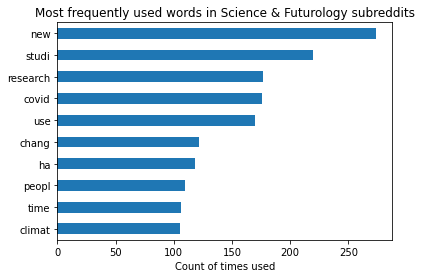

In [264]:
# Convert training data to dataframe
X = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

# Plot top occurring words
X.sum().sort_values(ascending = False).head(10)[::-1].plot(kind = 'barh')

plt.title('Most frequently used words in Science & Futurology subreddits')
plt.xlabel('Count of times used');

<br>

### Bag of Words analysis

#### TfidfVectorizer

The TF-IDF score indicates which words are important to a document, relative to all other documents.

Words that occur often in one document but don't occur in many documents contain more predictive power.

#### Create a document-term matrix to match up the subreddits and words

In [265]:
subred['title'] = subred['title'].apply(split_and_lemmatize)

subred_grouped_by_sub = subred[['subreddit', 'title']].groupby(by = 'subreddit').agg(lambda x: ' '.join(x))

# Create a document-term matrix

# Build a vocabulary that weights words on their importance to the corpus relative to the other documents in the corpus

tvec = TfidfVectorizer(max_features = 6_000,            # Limit words to those with a term frequency of 6,000 
                       stop_words = 'english',          # English stopwords
                       ngram_range = (1, 2)             # unigrams and bigrams
                      ) 

subred_grouped_by_sub_tvec = tvec.fit_transform(subred_grouped_by_sub['title'])

df_doc_term_matrix_tvec = pd.DataFrame(subred_grouped_by_sub_tvec.todense(), columns = tvec.get_feature_names())

df_doc_term_matrix_tvec['subreddit'] = subred_grouped_by_sub.index
subreddit_col = df_doc_term_matrix_tvec.pop('subreddit')
df_doc_term_matrix_tvec.insert(0, 'subreddit', subreddit_col)

display(df_doc_term_matrix)
df_doc_term_matrix_tvec

# ref: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

,subreddit,aalto,aalto univers,abandon,abandon invest,abdomen,abdomen larg,aberdeen,aberdeen citi,aberdeen develop,aberr,aberr synapt,abil,abil absorb,abil academ,abil adapt,abil avoid,abil contract,abil control,abil current,abil evalu,abil fight,abil identifi,abil lemur,abil magnetorecept,abil maintain,abil mindcontrol,abil neuron,abil peopl,abil reiter,abil secret,abil wait,abl,abl attribut,abl chang,abl follow,abl hangout,abl hit,abl just,abl make,abl rewir,abnorm,...,zero,zero carbon,zero cut,zero economi,zero emiss,zero plastic,zeroavia,zeroavia complet,zeroavia conduct,zeroavia retrofit,zerocarbon,zerocarbon hous,zeroemiss,zeroemiss concept,zeroemiss flight,zeroemiss fuel,zinc,zinc zn,zip,zip code,zip star,ziplin,ziplin unit,zircon,zircon hyperson,zn,zn base,zombi,zombi fires,zombi occur,zombi storm,zone,zone estuari,zoologist,zoologist uncov,zoom,zoom algorithm,zoom lapd,αcmₚmₑ½,αcmₚmₑ½ km,μg,μg dose
0,0,0,0,1,1,0,0,2,1,1,0,0,4,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,5,1,0,1,1,1,1,0,0,0,...,5,2,1,1,1,0,3,1,1,1,1,1,3,1,1,1,1,1,0,0,0,1,1,1,1,1,1,4,1,1,2,1,1,0,0,2,1,1,0,0,0,0
1,1,1,1,0,0,1,1,0,0,0,1,1,16,0,1,0,1,1,1,1,1,1,1,2,1,0,1,1,0,1,1,1,3,0,1,0,0,0,0,1,1,3,...,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,2,2


,subreddit,aberdeen,abil,abil lemur,abl,abnorm,abov,absolut,absorb,abstract,abstract acronym,abund,abus,academ,academi,academi scienc,acceler,acceler effort,accept,access,accommod,accord,accord major,accord new,accord research,accord studi,account,accur,accur predict,accuraci,ace,achiev,achiev close,acid,acoust,acquir,acronym,act,act like,act realiti,action,activ,...,worri,wors,worst,worth,wound,write,wrong,xpeng,xray,year,year ago,year amazon,year compar,year despit,year follow,year futur,year old,year report,year studi,yearold,yearold human,yield,york,young,young adult,younger,youth,youtub,zebrafish,zeolit,zeolit membran,zero,zero carbon,zero cut,zeroavia,zeroemiss,zip,zombi,zombi storm,zoom,μg,μg dose
0,futurology,0.006774,0.009640,0.000000,0.012050,0.000000,0.000000,0.002410,0.002410,0.000000,0.000000,0.002410,0.000000,0.000000,0.002410,0.002410,0.021689,0.000000,0.002410,0.012050,0.006774,0.014459,0.000000,0.004820,0.000000,0.000000,0.009640,0.007230,0.006774,0.000000,0.000000,0.009640,0.002410,0.000000,0.004820,0.000000,0.000000,0.014459,0.007230,0.002410,0.014459,0.012050,...,0.004820,0.004820,0.013548,0.009640,0.000000,0.006774,0.000000,0.006774,0.000000,0.118085,0.012050,0.006774,0.006774,0.002410,0.000000,0.006774,0.000000,0.006774,0.002410,0.004820,0.000000,0.002410,0.002410,0.004820,0.000000,0.000000,0.000000,0.002410,0.002410,0.002410,0.002410,0.012050,0.006774,0.002410,0.010161,0.010161,0.000000,0.013548,0.006774,0.006774,0.000000,0.000000
1,science,0.000000,0.027992,0.004918,0.005248,0.007376,0.009835,0.001749,0.001749,0.007376,0.004918,0.003499,0.004918,0.007376,0.001749,0.001749,0.012246,0.004918,0.003499,0.010497,0.000000,0.057733,0.004918,0.029741,0.007376,0.019671,0.012246,0.001749,0.000000,0.004918,0.004918,0.010497,0.001749,0.022129,0.001749,0.004918,0.009835,0.012246,0.003499,0.001749,0.010497,0.045486,...,0.001749,0.005248,0.000000,0.001749,0.004918,0.000000,0.007376,0.000000,0.009835,0.071729,0.010497,0.000000,0.000000,0.001749,0.007376,0.000000,0.012294,0.000000,0.003499,0.013996,0.004918,0.005248,0.003499,0.017495,0.012294,0.007376,0.004918,0.001749,0.001749,0.001749,0.001749,0.003499,0.000000,0.001749,0.000000,0.000000,0.004918,0.000000,0.000000,0.000000,0.004918,0.004918
